In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../src')
from utils import process_data
from utils import split_data

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
#from pmdarima.arima import auto_arima
from utils import train_naive
from utils import train_arima
from utils import predict_naive
from utils import predict_arima
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from utils import predict_regression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/data_01.txt', sep = '\t')

print(data.shape)
data.head()

(775466, 3)


,fecha,idTerminal,oper
0,2017-01-31 08:19:33.000,1828,0
1,2017-01-31 08:47:16.000,1828,1
2,2017-01-31 08:48:07.000,1828,1
3,2017-01-31 08:48:58.000,1828,1
4,2017-01-31 08:49:53.000,1828,1


In [3]:
lag_test = 15

In [4]:
# split data
train_raw, test_raw = split_data(data, lag_test = lag_test)

Test dataset is from 2017-05-17 to 2017-05-31


In [5]:
train_process = process_data(train_raw)
test_process  = process_data(test_raw)

In [6]:
print(train_process.shape)
train_process.head()

(44036, 6)


,dia,oper,idTerminal,num_trx,nombre_dia,weekend
0,2017-01-31,0,1507,21,Mar,0
1,2017-01-31,0,1537,69,Mar,0
2,2017-01-31,0,1574,83,Mar,0
3,2017-01-31,0,1575,64,Mar,0
4,2017-01-31,0,1577,200,Mar,0


**Ideas metodologicas:**

Por practicidad se considerará utilizar una metodología *top-down*, esto significa, proyectar el número de transacciones a nivel diario, y luego ir haciendo deep-dive hacia el top de operaciones y luego hacia el top de terminales.

In [7]:
train = train_process \
        .groupby(['dia', 'nombre_dia', 'weekend']) \
        .agg({'num_trx' : 'sum'}) \
        .reset_index()

In [8]:
test = test_process \
        .groupby(['dia', 'nombre_dia', 'weekend']) \
        .agg({'num_trx' : 'sum'}) \
        .reset_index()

In [9]:
print(train.shape)
train.head()

(106, 4)


,dia,nombre_dia,weekend,num_trx
0,2017-01-31,Mar,0,6028
1,2017-02-01,Mie,0,12760
2,2017-02-02,Jue,0,9246
3,2017-02-03,Vie,0,9667
4,2017-02-04,Sab,1,6212


Algo importante a notar, es que solo contamos con 106 días de información en nuestra data de entrenamiento, puede ser muy poca información para un modelo de series de tiempo o Machine Learning, sin embargo, se intentará ajustar un modelo de series de tiempo (ARIMA) y también se formulará como un problema de regresión con el fin de probar una Regresión Lineal y un Random Forest.

**Modelo Ingenuo (Baseline)**

El modelo ingenuo consiste en que el pronóstico será de la forma: $\hat{y}_t = y_{t-7}$
Es decir, el número de transacciones realizadas en la semana anterior.

In [10]:
model_naive = train_naive(train['num_trx'])
pred_naive = predict_naive(model_naive, periods = 15)

In [11]:
print(mean_absolute_percentage_error(test['num_trx'], pred_naive))
print(mean_squared_error(test['num_trx'], pred_naive, squared = False))

0.4257983689677947
2584.115619188378


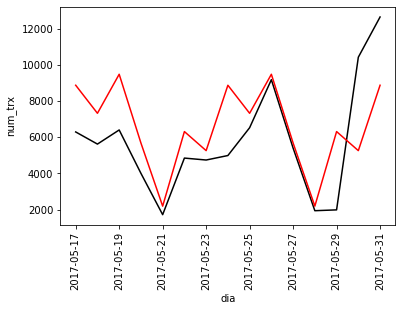

In [12]:
sns.lineplot(x = 'dia', y = 'num_trx', data = test, color = 'black')
sns.lineplot(x = test['dia'], y = pred_naive, color = 'red')
_ = plt.xticks(rotation = 90)

**Modelo ARIMA**

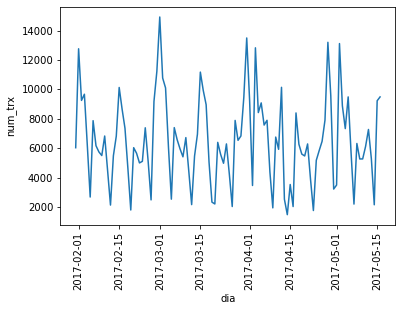

In [13]:
sns.lineplot(x = 'dia', y = 'num_trx', data = train)
_ = plt.xticks(rotation = 90)

El comportamiento del número de transacciones diarias parece no presentar ninguna tendencia, sin embargo la si parece tener momentos de mayor variabilidad que otros. Para considerar un **modelo ARIMA**, debemos evaluar si la serie presenta comportamiento estacionario, en primera instancia realizamos la transformación Box-Cox, con el fin de estabilizar su variabilidad.

In [14]:
x = train['num_trx'].values
xt, lmbda = stats.boxcox(x)

In [15]:
print('lambda:', lmbda)

lambda: 0.5675686227429437


Una vez la serie es estabilizada en varianza, probamos si debemos aplicar alguna **diferenciación** para estabilizar la serie en tendencia, por medio de la prueba estadística Dickey-Fuller Aumentada (ADF, por sus siglas en inglés).

**Hipótesis:**

**$H_0$:** La serie **no** es estacionaria, por lo tanto necesita diferenciación.

**$H_1$:** La serie **es** estacionaria, por lo tanto no necesita diferenciación.

In [16]:
result = adfuller(xt)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.378344
p-value: 0.000324


Se obtuvo un p-value cercano a 0, por lo que a un nivel de significancia del 5% se rechaza **$H_0$**, podemos concluir que la serie es estacionaria.

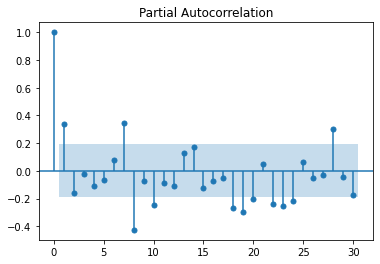

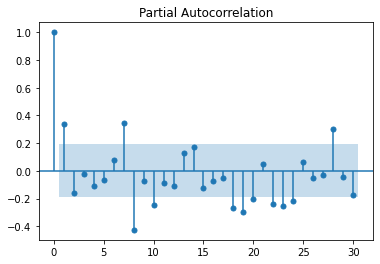

In [17]:
plot_pacf(xt, lags = 30)

Utilizando el comportamiento de la función de autocorrelación y la función de autocorrelación parcial, se evidencian que los rezagos significativos son el 1, 7 y 8. Luego de varias iteraciones el modelo que pudo converger fue $ARIMA(7, 0, 1)$.

Por temas de tiempo asumiremos que el modelo cumple con los supuestos de Normalidad y No autocorrelación.

In [18]:
model_arima = train_arima(xt, p = 7, d = 0, q = 1)
pred_arima  = predict_arima(model_arima, periods = 15, lmbda = lmbda)

In [19]:
print(mean_absolute_percentage_error(test['num_trx'], pred_arima))
print(mean_squared_error(test['num_trx'], pred_arima, squared = False))

0.5673699732258858
2793.105989550871


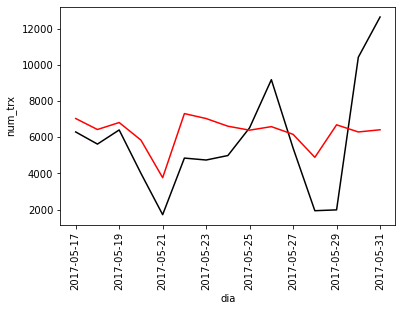

In [20]:
sns.lineplot(x = 'dia', y = 'num_trx', data = test, color = 'black')
sns.lineplot(x = test['dia'], y = pred_arima, color = 'red')
_ = plt.xticks(rotation = 90)

**Enfoque de regresón**

In [21]:
train['lag1'] = train['num_trx'].shift(1)
train['lag7'] = train['num_trx'].shift(7)

test['lag1'] = np.nan
test['lag7'] = np.nan

In [22]:
total = pd.concat([train, test])
total['lag1'] = total['num_trx'].shift(1)
total['lag7'] = total['num_trx'].shift(7)

test = total[-lag_test:]

In [23]:
test.loc[1:, 'lag1'] = None
test.loc[7:, 'lag7'] = None

In [24]:
train_ml = train.dropna()
test_ml  = test.copy()

In [25]:
y_train = train_ml['num_trx'].values
X_train = train_ml[['weekend', 'lag1', 'lag7']]

In [26]:
y_test = test_ml['num_trx'].values
X_test = test_ml[['weekend', 'lag1', 'lag7']]

**Regresión Lineal**

In [27]:
train.corr()

,weekend,num_trx,lag1,lag7
weekend,1.000000,-0.649395,0.016755,-0.527726
num_trx,-0.649395,1.000000,0.363678,0.239461
lag1,0.016755,0.363678,1.000000,-0.009566
lag7,-0.527726,0.239461,-0.009566,1.000000


In [28]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [29]:
pred_lr = predict_regression(X_test, model = lr)

In [30]:
print(mean_absolute_percentage_error(test['num_trx'], pred_lr))
print(mean_squared_error(test['num_trx'], pred_lr, squared = False))

0.3848575829879256
2531.2338161965004


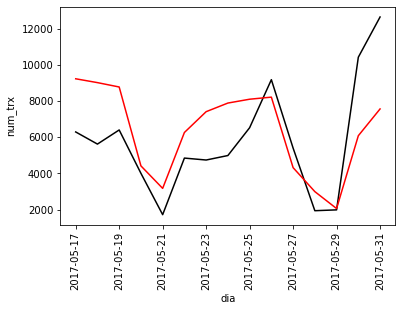

In [31]:
sns.lineplot(x = 'dia', y = 'num_trx', data = test, color = 'black')
sns.lineplot(x = test['dia'], y = pred_lr, color = 'red')
_ = plt.xticks(rotation = 90)

**Random Forest**

In [45]:
rf = RandomForestRegressor(random_state = 123)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=123)

In [46]:
pred_rf = predict_regression(X_test, model = rf)

In [47]:
print(mean_absolute_percentage_error(test['num_trx'], pred_rf))
print(mean_squared_error(test['num_trx'], pred_rf, squared = False))

0.3341462291053641
2541.0391369267286


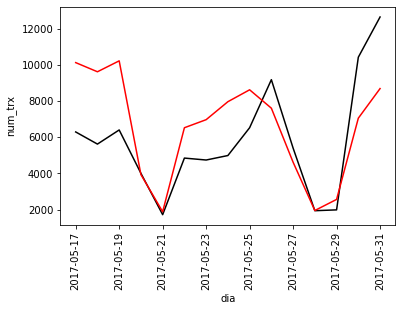

In [48]:
sns.lineplot(x = 'dia', y = 'num_trx', data = test, color = 'black')
sns.lineplot(x = test['dia'], y = pred_rf, color = 'red')
_ = plt.xticks(rotation = 90)

**Predicciones consolidadas**

In [49]:
df_results = pd.DataFrame({'dia'  : test['dia'],
                           'real' : test['num_trx'],
                           'baseline': pred_naive,
                           'arima' : pred_arima,
                           'lr' : pred_lr,
                           'rf' : pred_rf})

In [50]:
df_metrics = {}
df_metrics['model'] = []
df_metrics['mape'] = []
df_metrics['rmse'] = []

for x in ['baseline', 'arima', 'lr', 'rf']:
    
    mape = mean_absolute_percentage_error(df_results['real'], df_results[x])
    rmse = mean_squared_error(df_results['real'], df_results[x], squared = False)
    
    df_metrics['model'].append(x)
    df_metrics['mape'].append(mape)
    df_metrics['rmse'].append(rmse)

df_metrics = pd.DataFrame(df_metrics)

In [51]:
df_metrics

,model,mape,rmse
0,baseline,0.425798,2584.115619
1,arima,0.567370,2793.105990
2,lr,0.384858,2531.233816
3,rf,0.334146,2541.039137


Dado que el modelo **Random Forest** presenta el **menor** MAPE y su RMSE es muy similar a la regresión lineal, será seleccionado como **mejor modelo** dentro del champion challenge.

**Proyección por operación y terminal**

In [52]:
date_compute_share = sorted(train_process['dia'].unique())[-lag_test]

In [53]:
last_days = train_process[train_process['dia'] >= date_compute_share]

In [74]:
top_oper = [0, 3, 1, 7, 4]
top_term = [1908, 1964, 1774, 1910, 1980]

In [55]:
agg_last_days = last_days \
                .groupby(['dia', 'weekend']) \
                .agg({'num_trx': 'sum'})

agg_last_days_oper = last_days \
                    .groupby(['dia', 'weekend', 'oper'], as_index = False) \
                    .agg({'num_trx': 'sum'})

agg_last_days_oper = agg_last_days_oper.set_index(['dia', 'weekend'])
agg_last_days_oper = agg_last_days_oper.rename(columns = {'num_trx': 'num_trx_oper'})

agg_last_days_oper = agg_last_days_oper.join(agg_last_days)

agg_last_days_oper['share'] = agg_last_days_oper['num_trx_oper'] / agg_last_days_oper['num_trx']

agg_last_days_oper = agg_last_days_oper.reset_index()

In [56]:
share_oper = agg_last_days_oper \
             .groupby(['oper', 'weekend'], as_index = False) \
             .agg({'share': 'mean'})

share_oper = share_oper[share_oper['oper'].isin(top_oper)]
share_oper = share_oper.pivot_table(index = ['weekend'], columns = 'oper')
share_oper.columns = ['oper_' + str(x[1]) for x in share_oper.columns]

In [57]:
final_predictions = test.copy()
final_predictions['pred'] = pred_rf
final_predictions = final_predictions[['dia', 'weekend', 'num_trx', 'pred']]
final_predictions = final_predictions \
                    .set_index('weekend') \
                    .join(share_oper)

In [58]:
for x in share_oper.columns:
    final_predictions[x] = final_predictions[x] * final_predictions['pred']

In [59]:
final_predictions = final_predictions.sort_values('dia')

In [64]:
final_predictions = final_predictions.reset_index()
final_predictions = final_predictions.set_index('dia')

In [68]:
# Real oper values
test_real_oper = test_process \
                .query('oper in @top_oper') \
                .groupby(['dia', 'oper'], as_index = False) \
                .agg({'num_trx': 'sum'}) \
                .pivot_table(index = 'dia', columns = 'oper')

test_real_oper.columns = share_oper.columns + '_real'

In [71]:
df_results_oper = test_real_oper.join(final_predictions)

In [72]:
df_metrics = {}
df_metrics['oper'] = []
df_metrics['mape'] = []
df_metrics['rmse'] = []

for x in share_oper.columns:
    
    mape = mean_absolute_percentage_error(df_results_oper[x + '_real'], df_results_oper[x])
    rmse = mean_squared_error(df_results_oper[x + '_real'], df_results_oper[x], squared = False)
    
    df_metrics['oper'].append(x)
    df_metrics['mape'].append(mape)
    df_metrics['rmse'].append(rmse)

df_metrics = pd.DataFrame(df_metrics)

In [73]:
df_metrics

,oper,mape,rmse
0,oper_0,0.368835,1551.147928
1,oper_1,0.252663,190.207614
2,oper_3,0.368814,433.361340
3,oper_4,0.479398,149.666610
4,oper_7,0.184605,114.646373


La operación 4 es la que presenta mayor **MAPE** y la operacion 7 presenta estimaciones **más precisas**.

Ahora bien, ya que tenemos las estimaciones por operación seguimos yendo hacia la granularidad de terminal, utilizando el mismo mecanismo de share, pero en este caso sería el share de cada terminal dentro de cada operación.

In [90]:
df_results_oper = df_results_oper.reset_index()

In [109]:
df_results_oper2 = df_results_oper[['dia', 'weekend','oper_0', 'oper_1', 'oper_3', 'oper_4', 'oper_7']] \
                   .melt(id_vars = ['dia', 'weekend'])

In [110]:
df_results_oper2.columns = ['dia', 'weekend', 'oper', 'pred_oper']

In [116]:
df_results_oper2

,dia,weekend,oper,pred_oper
0,2017-05-17,0,oper_0,5559.443109
1,2017-05-18,0,oper_0,5281.494005
2,2017-05-19,0,oper_0,5613.064789
3,2017-05-20,1,oper_0,2058.623162
4,2017-05-21,1,oper_0,984.282499
...,...,...,...,...
70,2017-05-27,1,oper_7,391.309507
71,2017-05-28,1,oper_7,165.261326
72,2017-05-29,1,oper_7,217.161115
73,2017-05-30,0,oper_7,508.532806


In [120]:
# Por terminal
#agg_last_days_oper_term = last_days.set_index(['dia'])
agg_last_days_oper_term = last_days.copy()
agg_last_days_oper_term = agg_last_days_oper_term[agg_last_days_oper_term['idTerminal'].isin(top_term)]
agg_last_days_oper_term = agg_last_days_oper_term.rename(columns = {'num_trx': 'num_trx_term'})
agg_last_days_oper_term = agg_last_days_oper_term.drop(columns = ['nombre_dia', 'weekend'])

agg_last_days_oper_term = agg_last_days_oper.merge(agg_last_days_oper_term,
                                                   on = ['dia', 'oper'])

agg_last_days_oper_term['share_term'] = agg_last_days_oper_term['num_trx_term'] / agg_last_days_oper_term['num_trx_oper']

agg_last_days_oper_term['oper'] = 'oper_' + agg_last_days_oper_term['oper'].astype(str)

In [126]:
agg_last_days_oper_term = agg_last_days_oper_term \
                            .groupby(['weekend', 'oper', 'idTerminal'], as_index = False) \
                            .agg({'share_term': 'mean'}) \
                            .merge(df_results_oper2, on = ['weekend', 'oper'])

In [128]:
agg_last_days_oper_term['pred_term'] = agg_last_days_oper_term['pred_oper'] * agg_last_days_oper_term['share_term']

In [130]:
agg_last_days_oper_term.head(20)

,weekend,oper,idTerminal,share_term,dia,pred_oper,pred_term
0,0,oper_0,1774,0.036610,2017-05-17,5559.443109,203.529390
1,0,oper_0,1774,0.036610,2017-05-18,5281.494005,193.353765
2,0,oper_0,1774,0.036610,2017-05-19,5613.064789,205.492462
3,0,oper_0,1774,0.036610,2017-05-22,3582.894192,131.168582
4,0,oper_0,1774,0.036610,2017-05-23,3827.375026,140.118945
5,0,oper_0,1774,0.036610,2017-05-24,4372.911132,160.090843
6,0,oper_0,1774,0.036610,2017-05-25,4734.283935,173.320583
7,0,oper_0,1774,0.036610,2017-05-26,4175.888505,152.877910
8,0,oper_0,1774,0.036610,2017-05-30,3872.813500,141.782433
9,0,oper_0,1774,0.036610,2017-05-31,4771.517249,174.683683


**TO DO:**

* Desplegar la solución desarrollada.
* Evaluar metricas por terminal.
* Evaluar el ajuste de una red neuronal recurrente, la poca cantidad de datos podria no hacer funcionar este enfoque, sin embargo se podría hacer el ejercicio de evaluar.
* Se podría pensar en construir un modelo por operación. Un modelo por operación y terminal podria volverse muy complejo de mantener y desplegar en producción, adicionalmente sería muy variable las estimaciones debido al bajo volumen de transacciones que hay por terminal.